Processing pair: Fast-Stacks1
File: C:\Users\clchr\Downloads\Round 2\Fast-DAPI-Phalloidin-100X-Stacks1.nd2
Number of channels: 2
Total number of z-stacks: 5
Number of slices per z-stack: 11

Processing Z-Stack 1


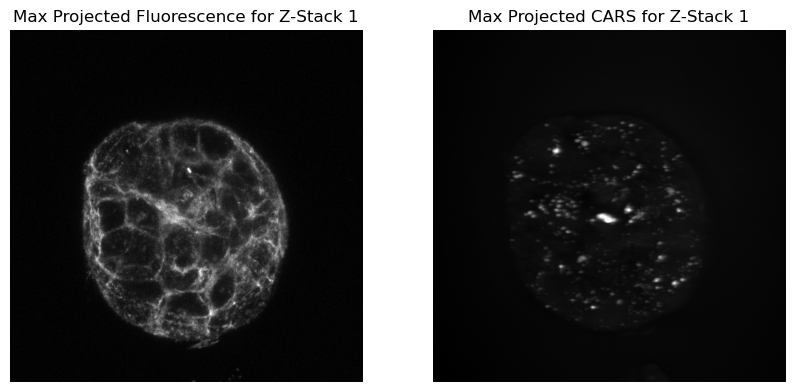

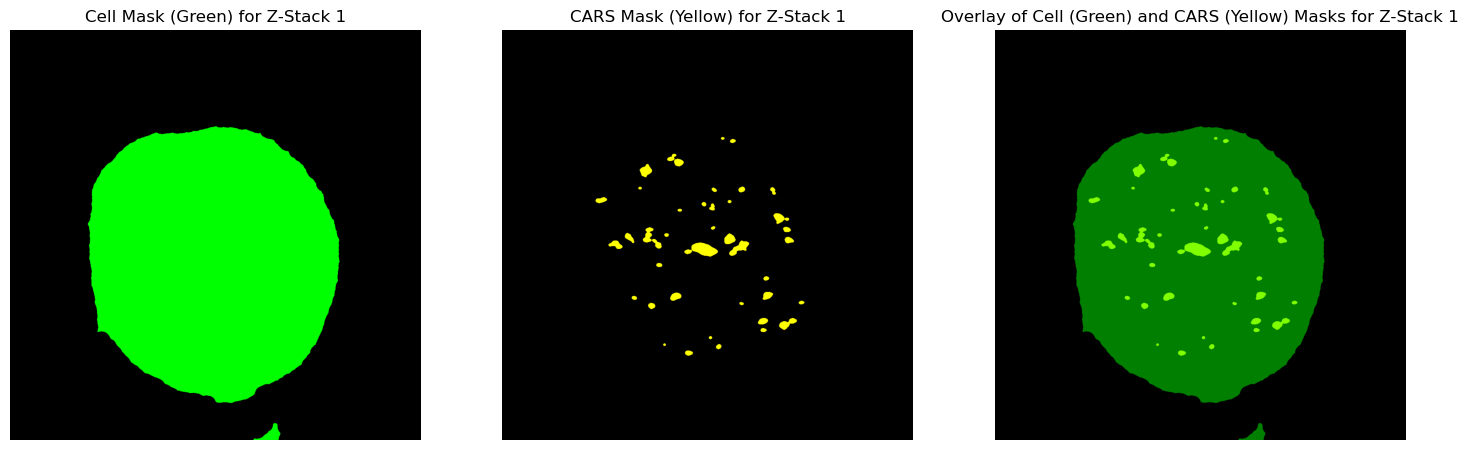


Processing Z-Stack 2


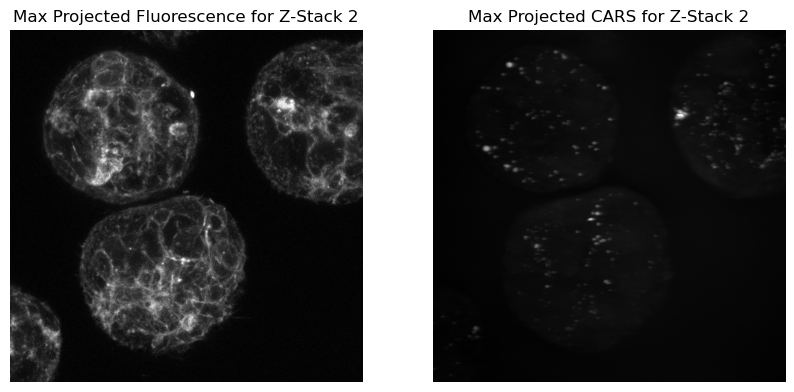

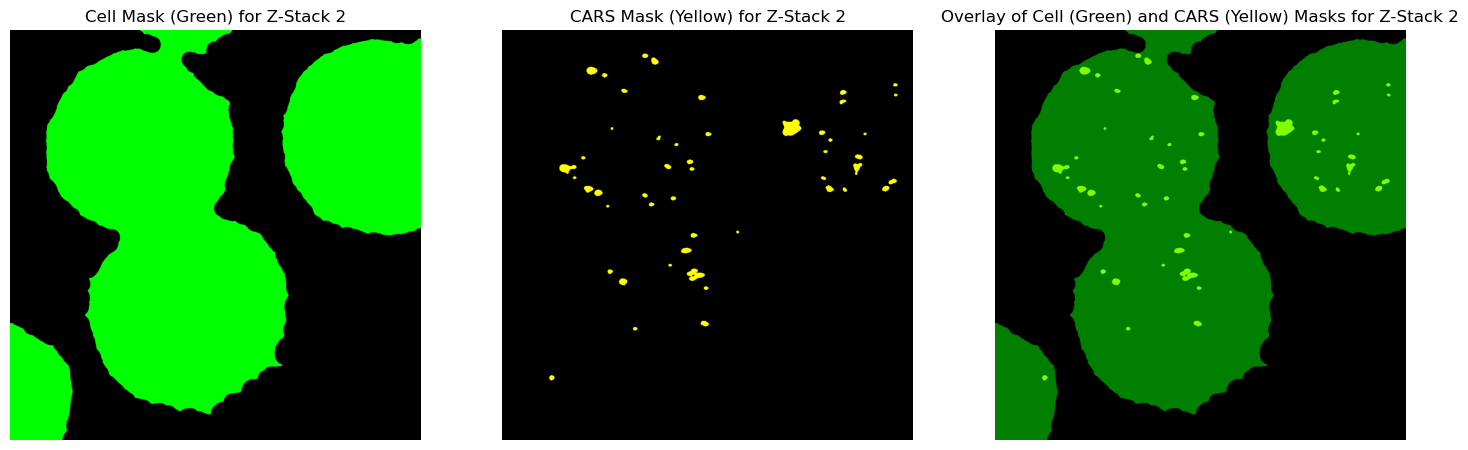


Processing Z-Stack 3


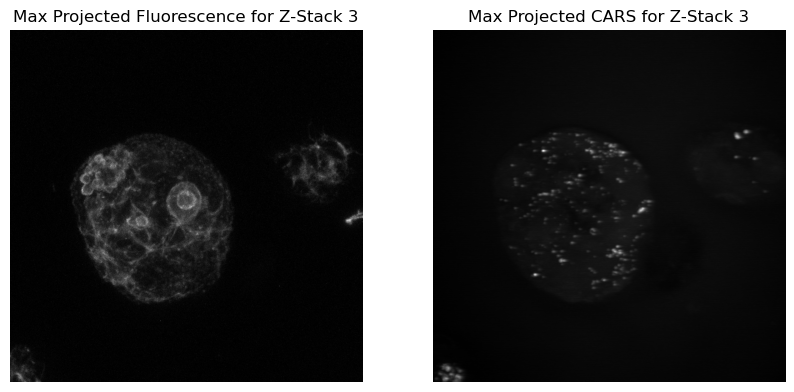

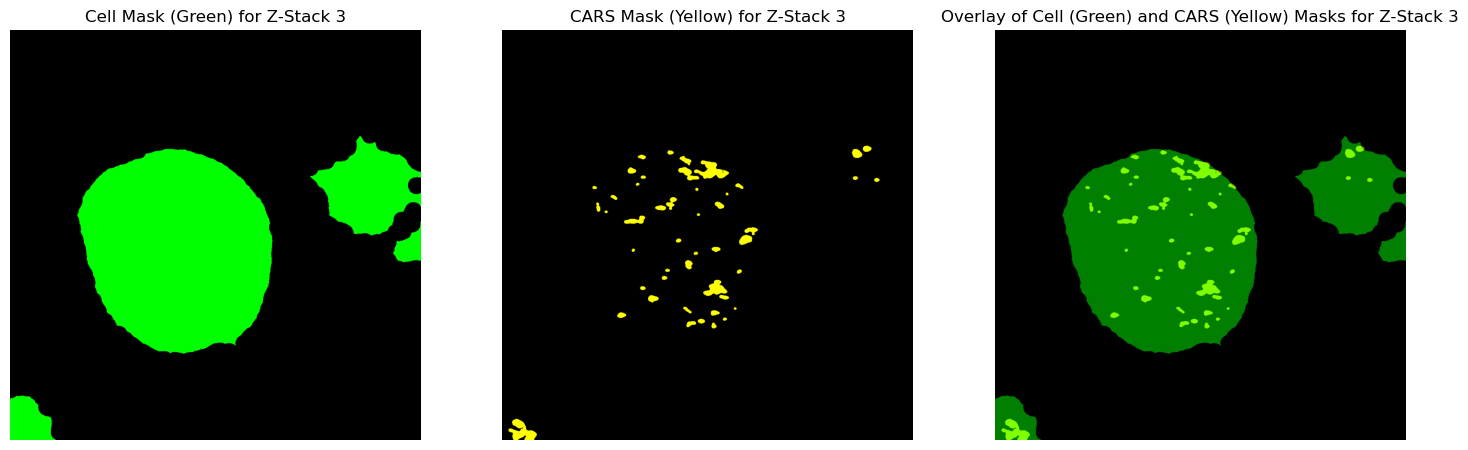


Processing Z-Stack 4


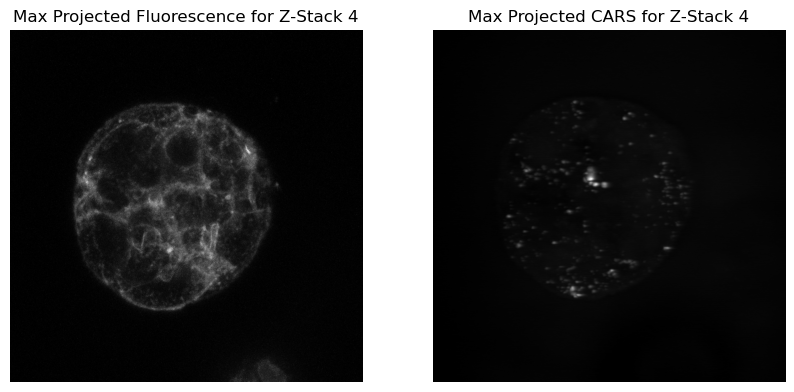

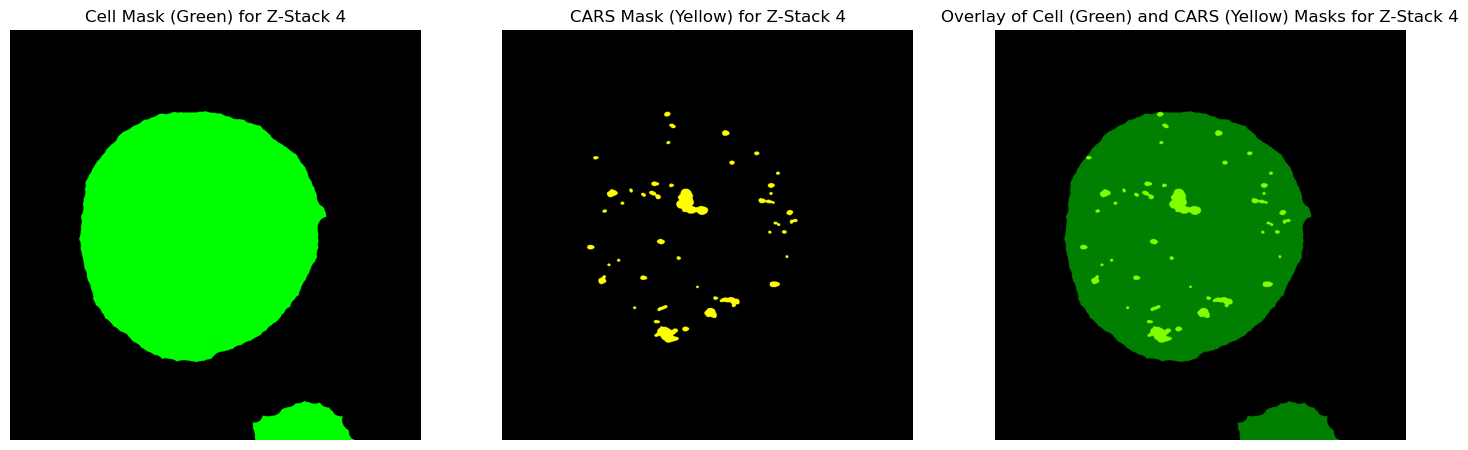


Processing Z-Stack 5


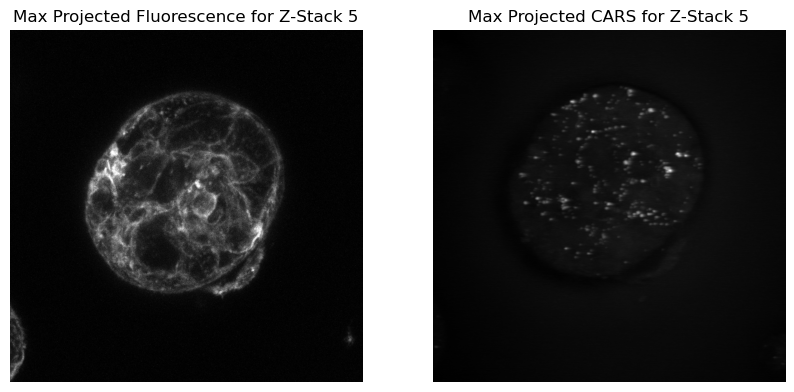

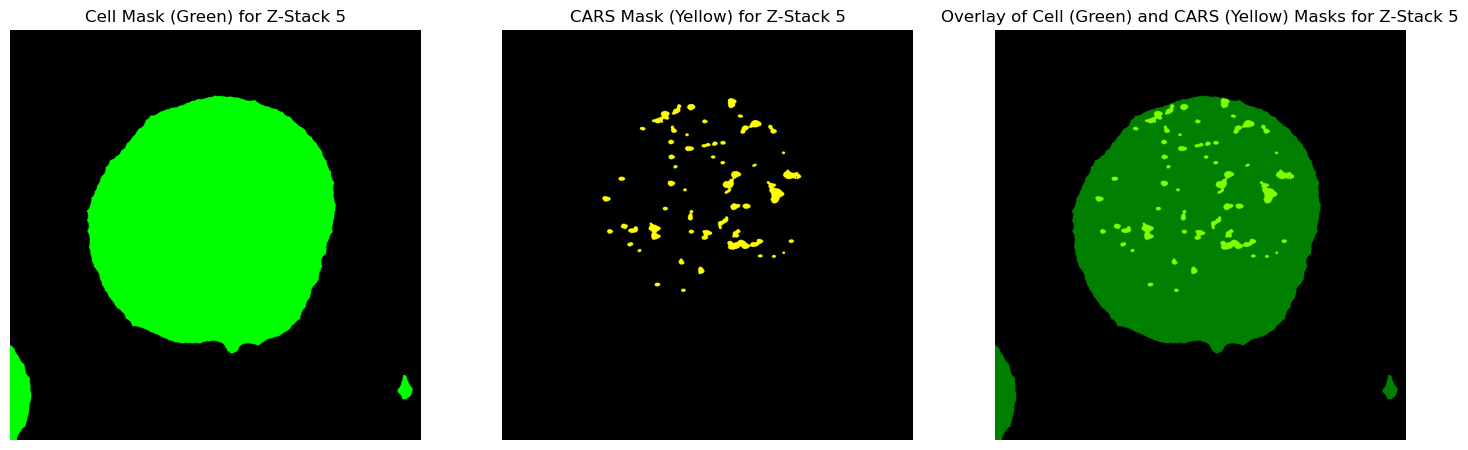

Processing pair: Fast-Stacks2
File: C:\Users\clchr\Downloads\Round 2\Fast-DAPI-Phalloidin-100X-Stacks2.nd2
Number of channels: 2
Total number of z-stacks: 5
Number of slices per z-stack: 11

Processing Z-Stack 1


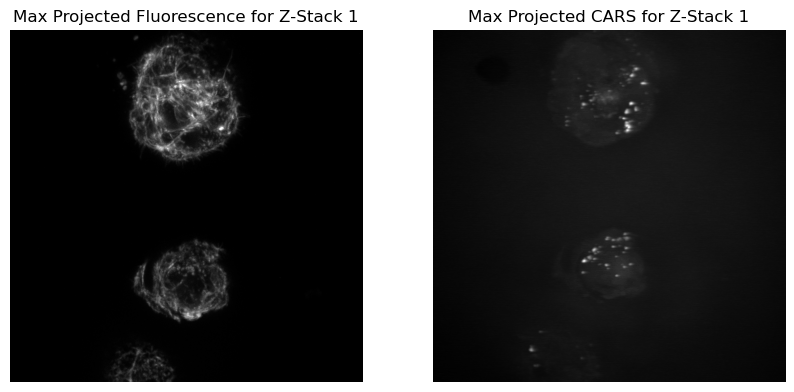

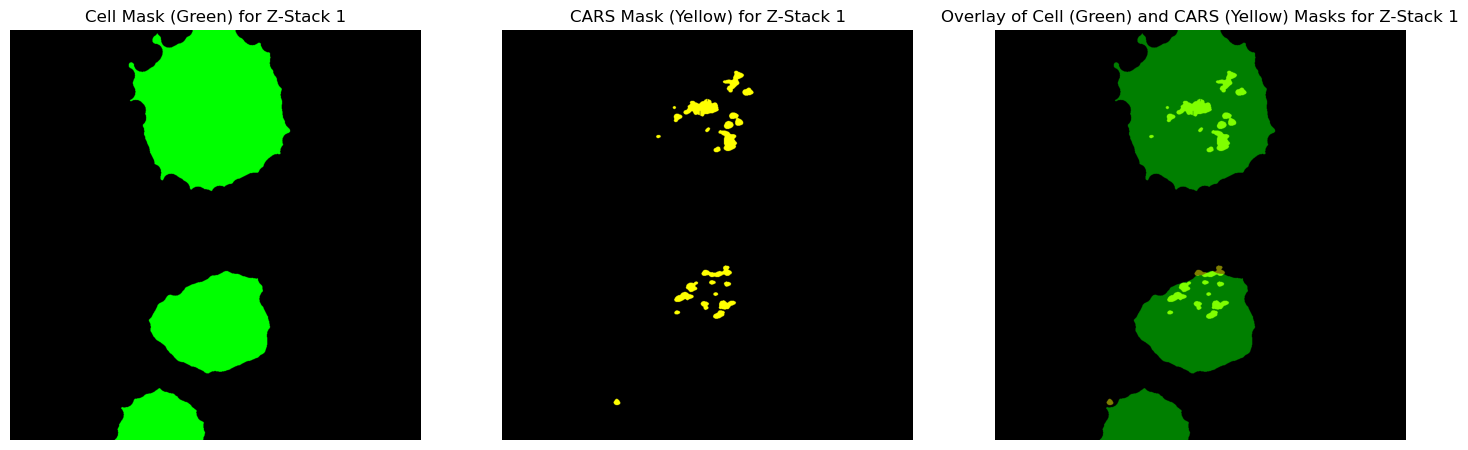


Processing Z-Stack 2


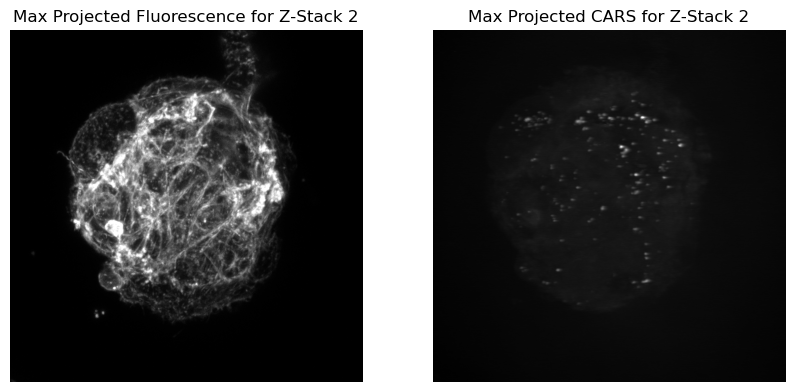

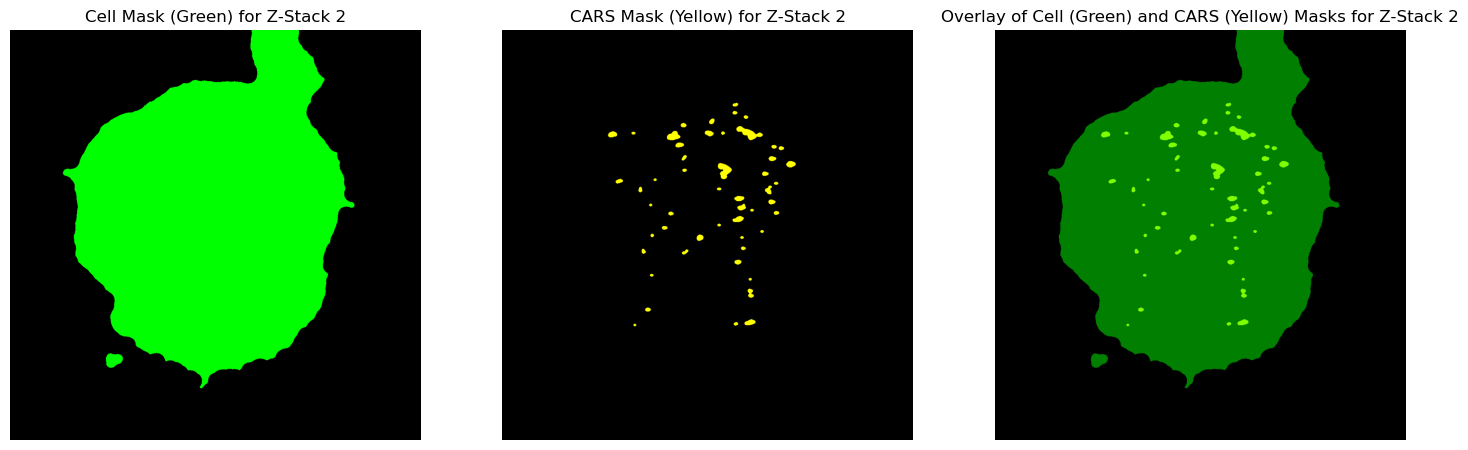


Processing Z-Stack 3


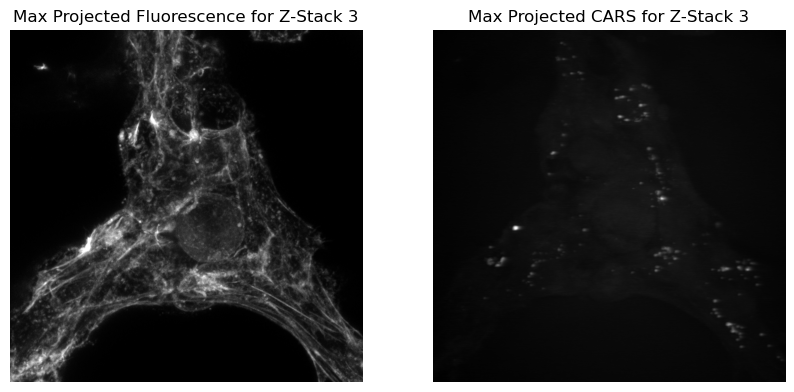

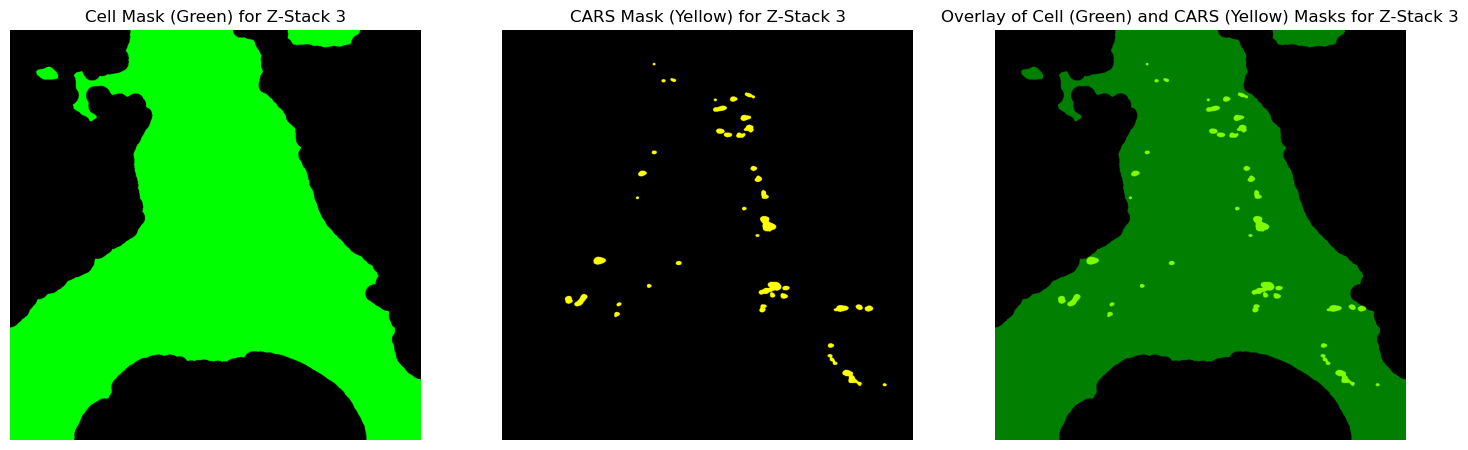


Processing Z-Stack 4


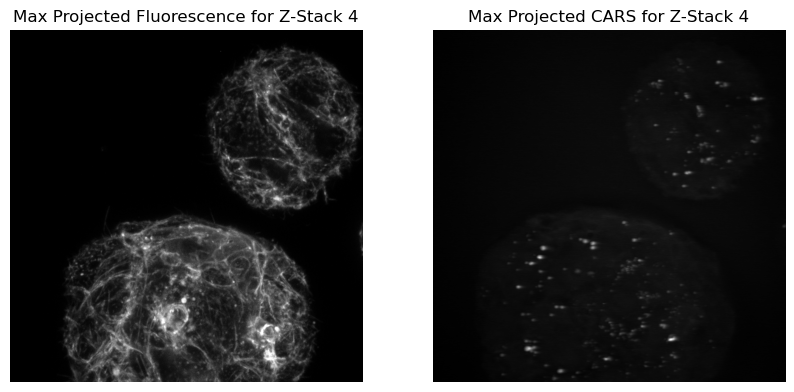

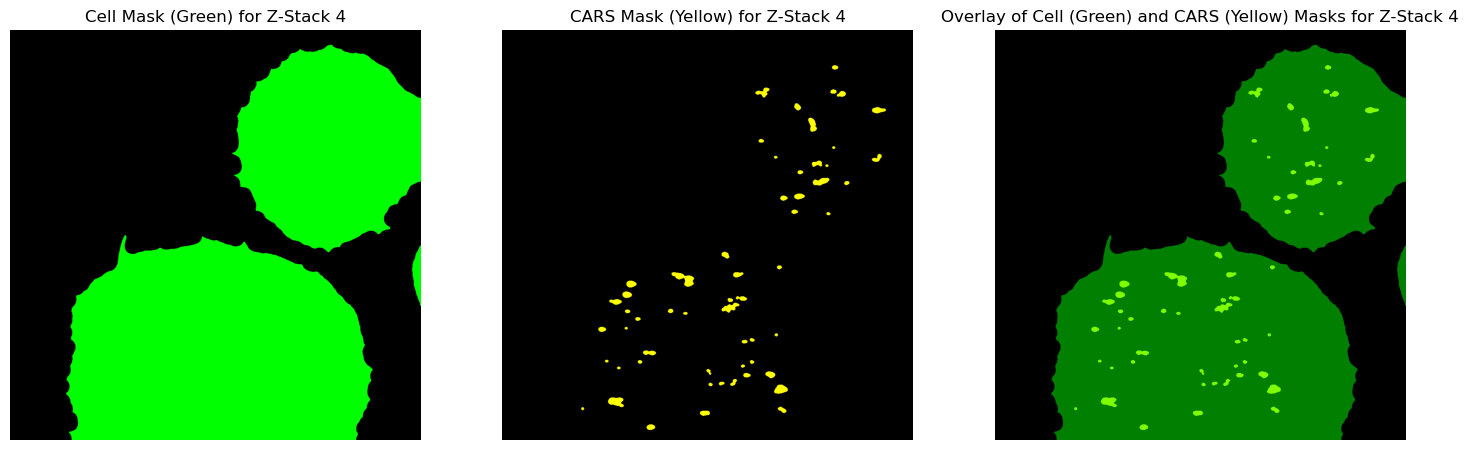


Processing Z-Stack 5


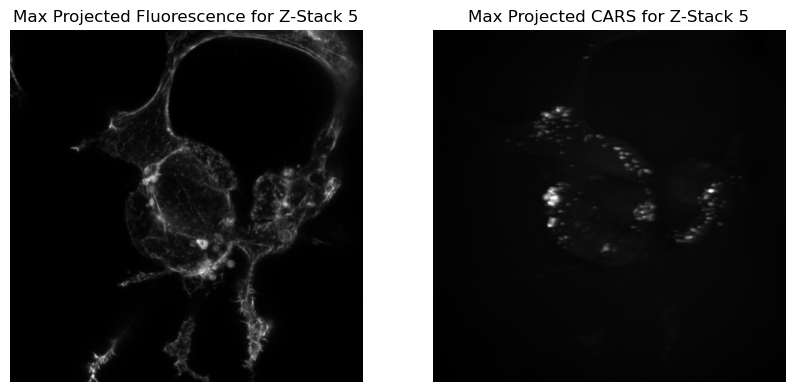

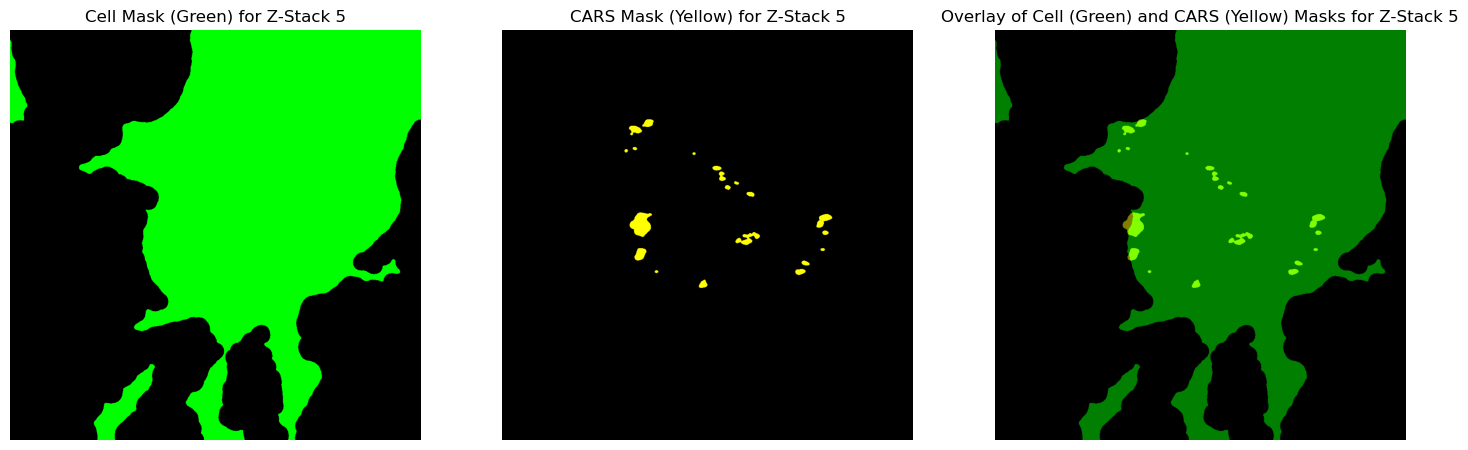

Processing pair: Fast-Stacks3
File: C:\Users\clchr\Downloads\Round 2\Fast-DAPI-Phalloidin-100X-Stacks3.nd2
Number of channels: 2
Total number of z-stacks: 5
Number of slices per z-stack: 11

Processing Z-Stack 1


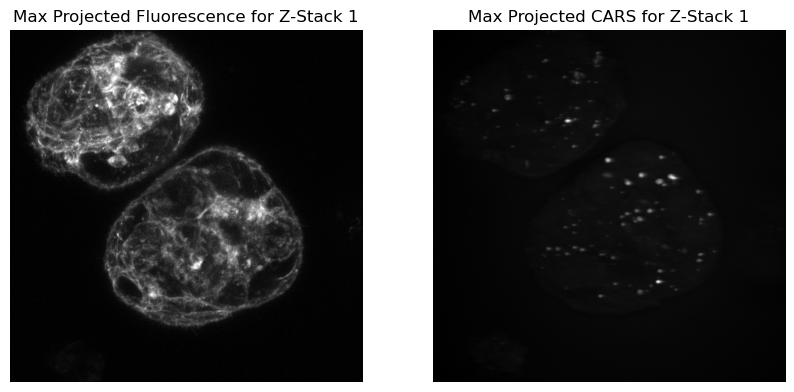

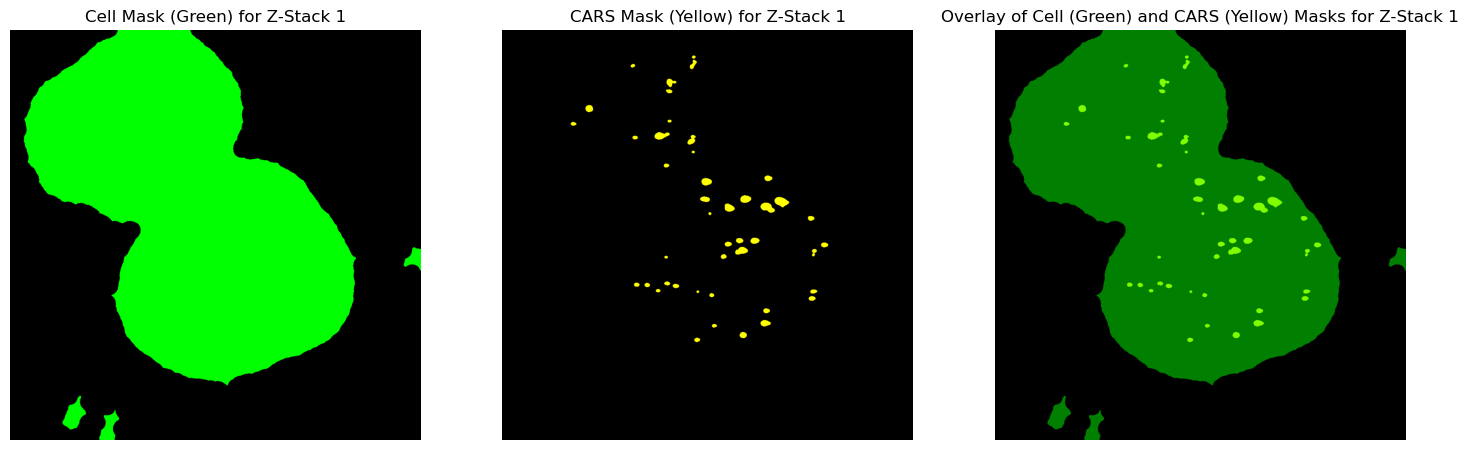


Processing Z-Stack 2


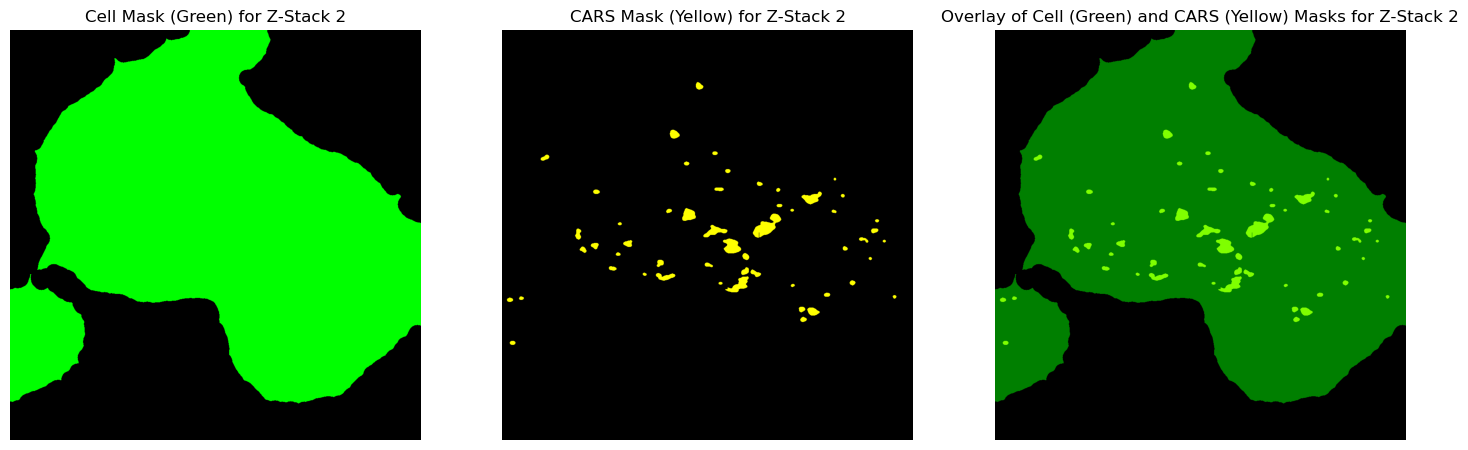


Processing Z-Stack 3


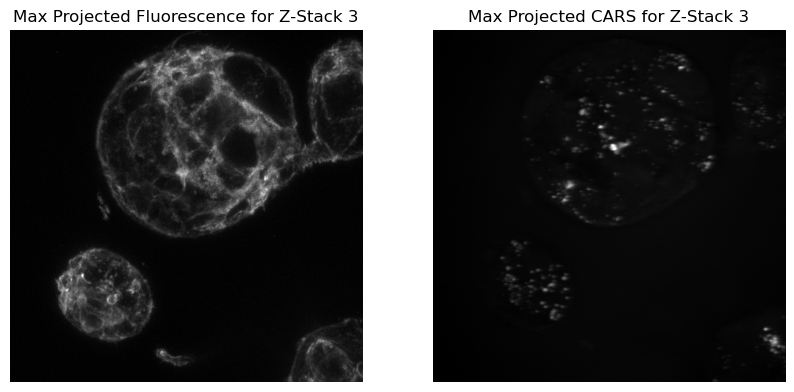

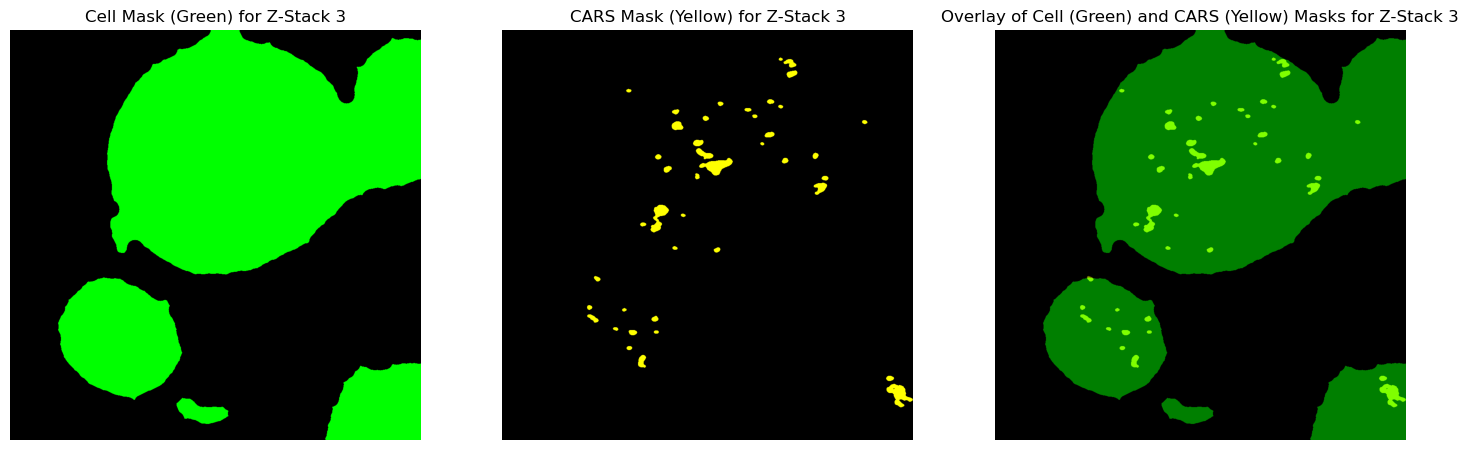


Processing Z-Stack 4


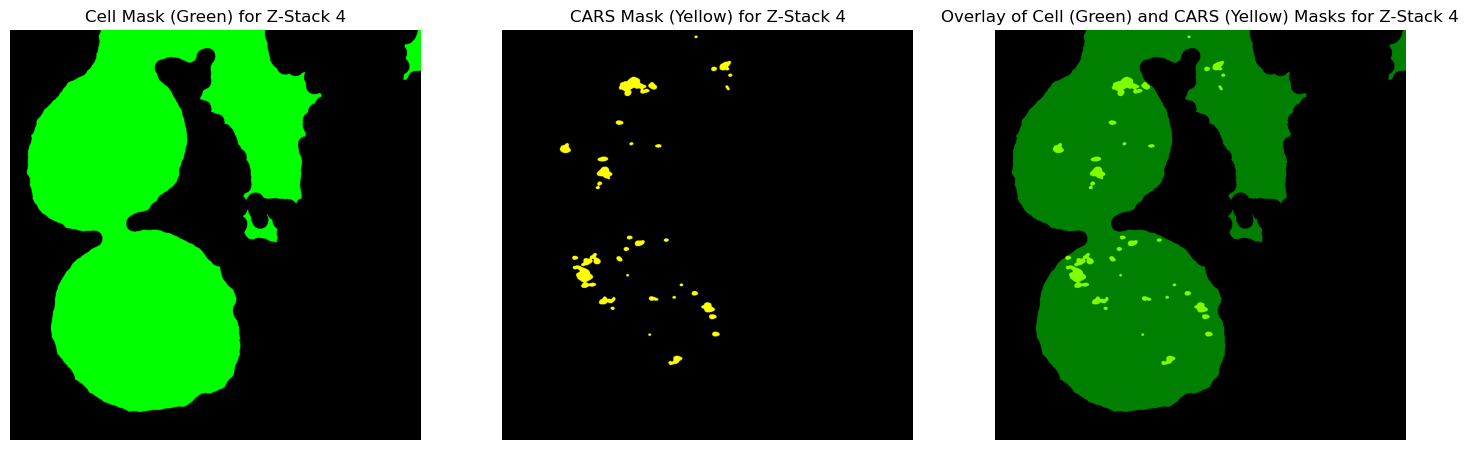


Processing Z-Stack 5


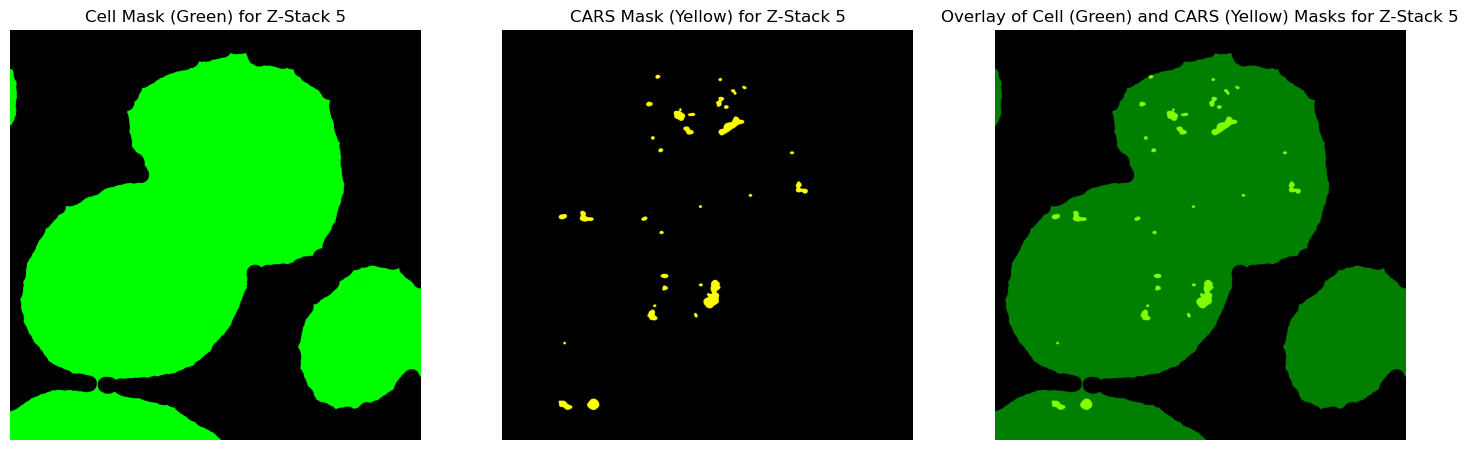

Processing pair: Slow-Stacks1
File: C:\Users\clchr\Downloads\Round 2\Slow-DAPI-Phalloidin-100X-Stacks1.nd2
Number of channels: 2
Total number of z-stacks: 5
Number of slices per z-stack: 11

Processing Z-Stack 1


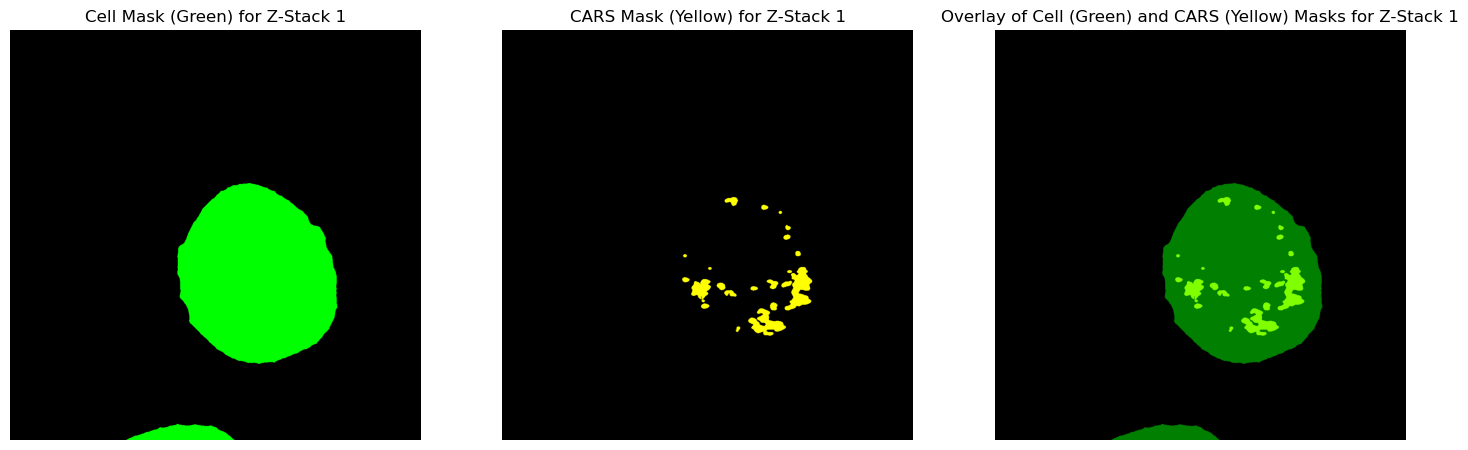


Processing Z-Stack 2


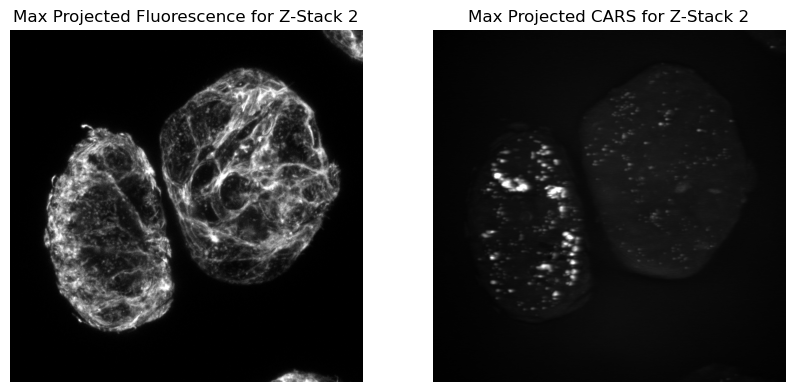


Processing Z-Stack 3


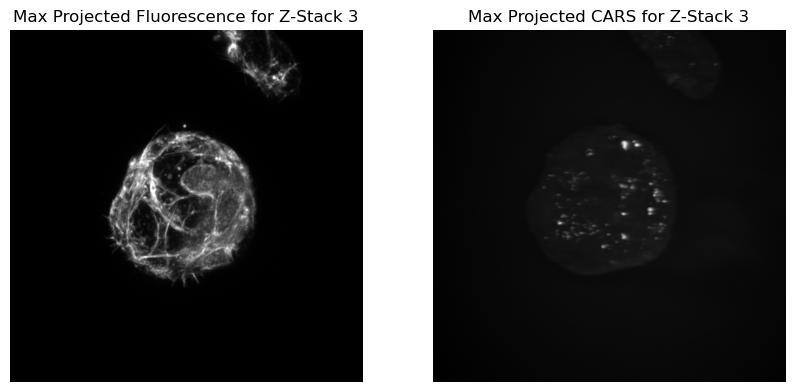

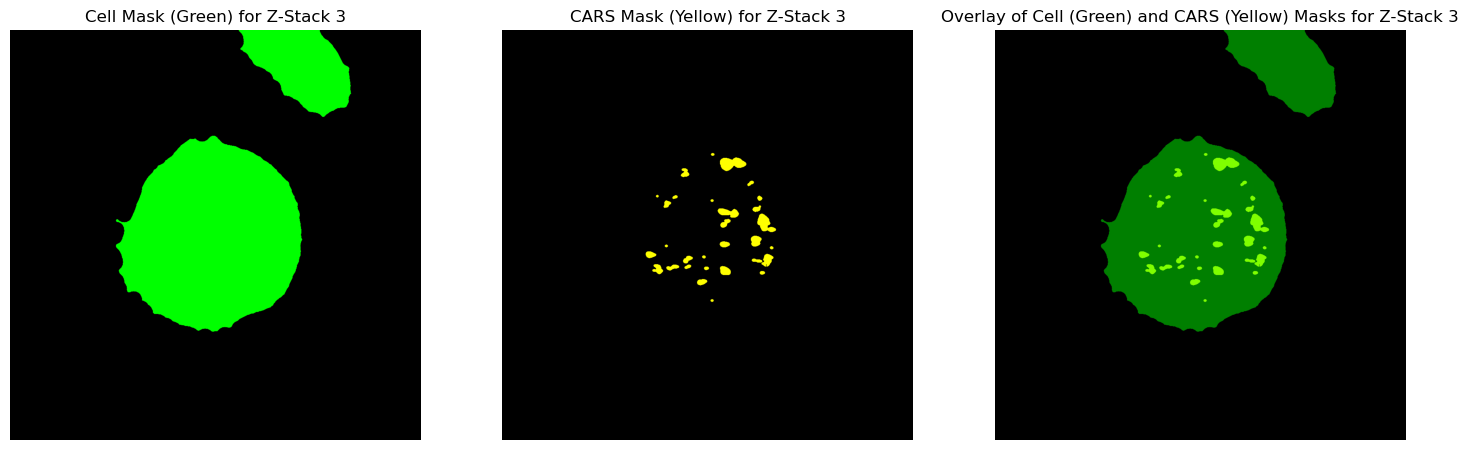


Processing Z-Stack 4



Processing Z-Stack 5


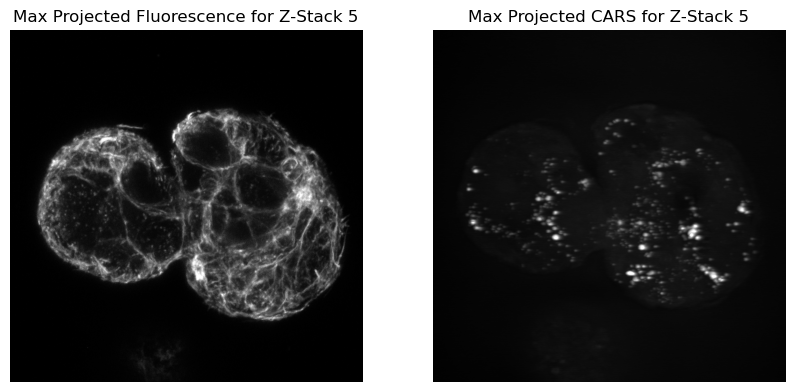

Processing pair: Slow-Stacks2
File: C:\Users\clchr\Downloads\Round 2\Slow-DAPI-Phalloidin-100X-Stacks2.nd2
Number of channels: 2
Total number of z-stacks: 5
Number of slices per z-stack: 11

Processing Z-Stack 1


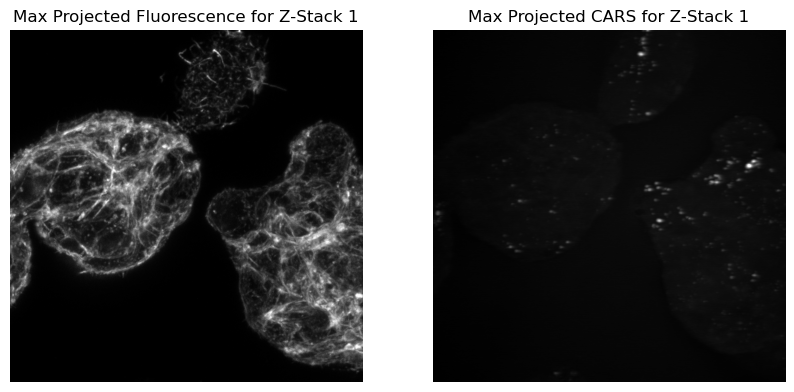


Processing Z-Stack 2


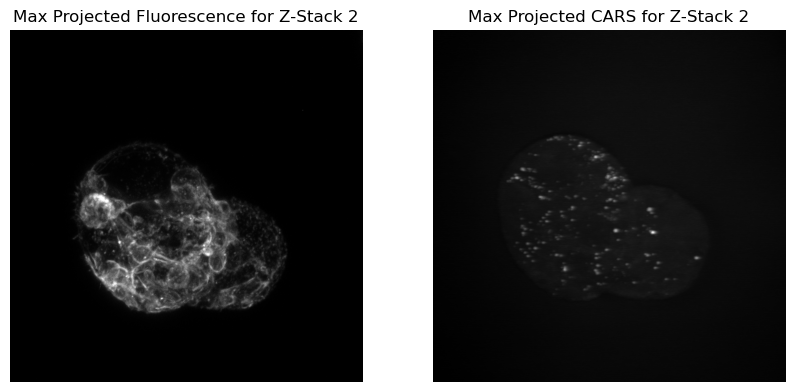


Processing Z-Stack 3


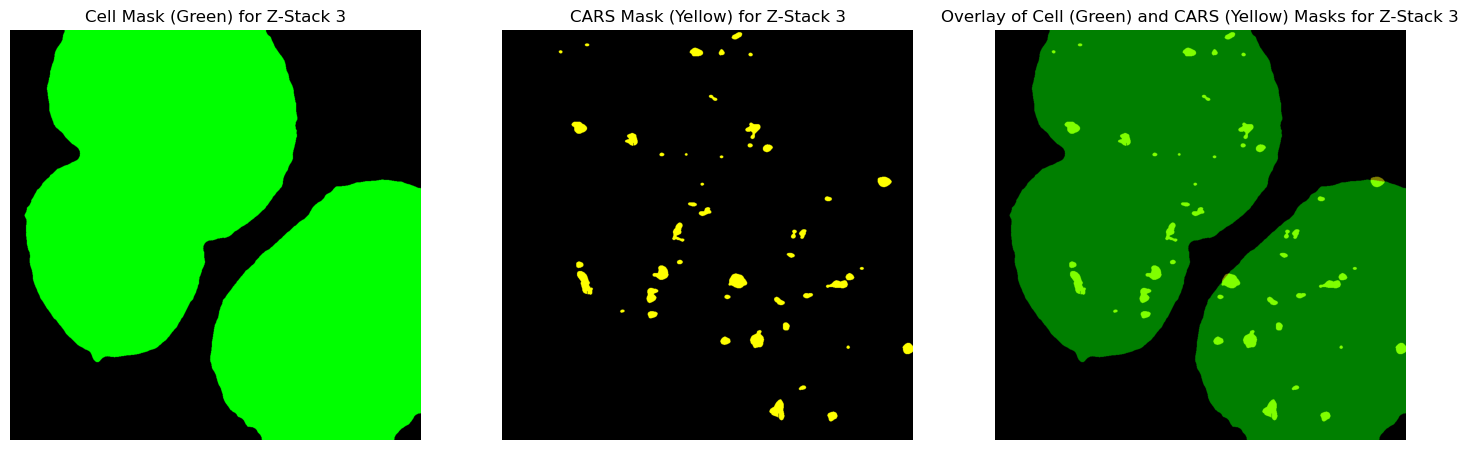


Processing Z-Stack 4



Processing Z-Stack 5


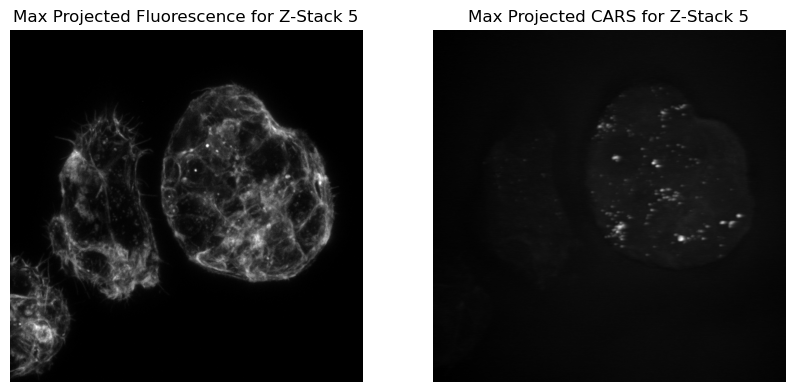

Processing pair: Slow-Stacks3
File: C:\Users\clchr\Downloads\Round 2\Slow-DAPI-Phalloidin-100X-Stacks3.nd2
Number of channels: 2
Total number of z-stacks: 5
Number of slices per z-stack: 11

Processing Z-Stack 1


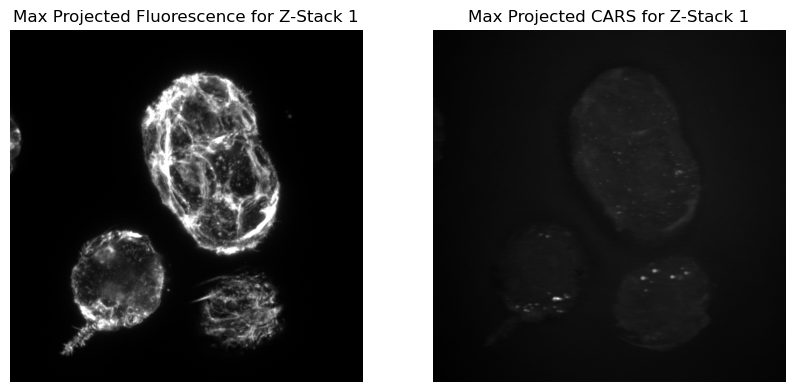


Processing Z-Stack 2


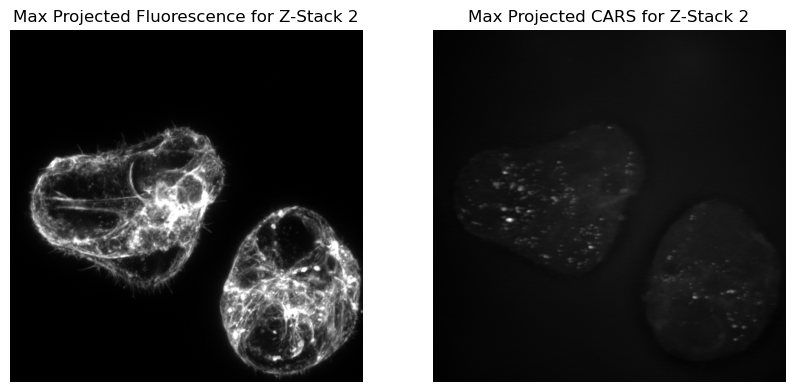


Processing Z-Stack 3


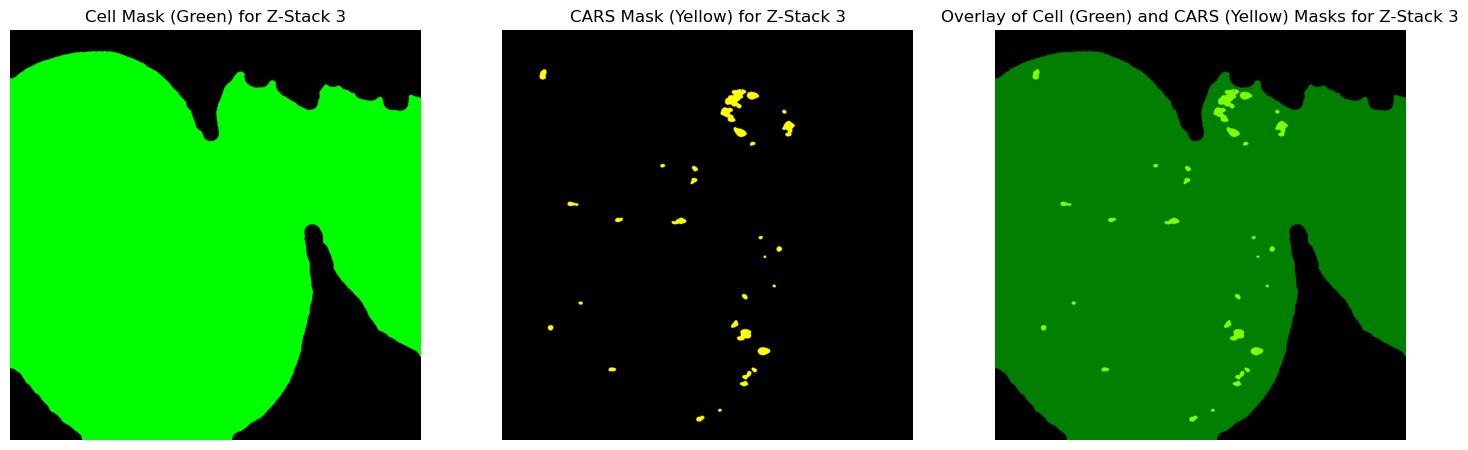


Processing Z-Stack 4


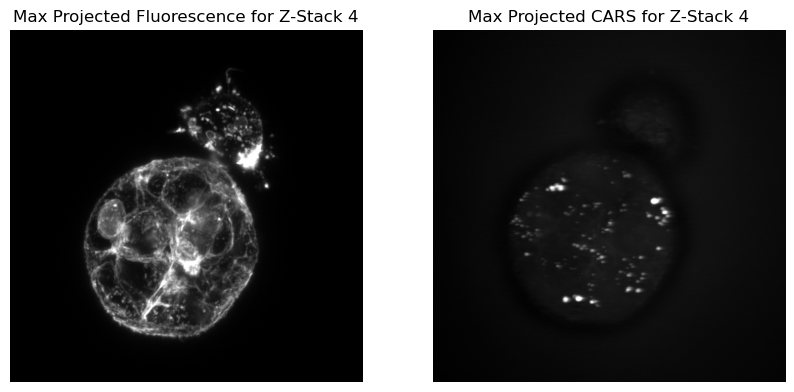

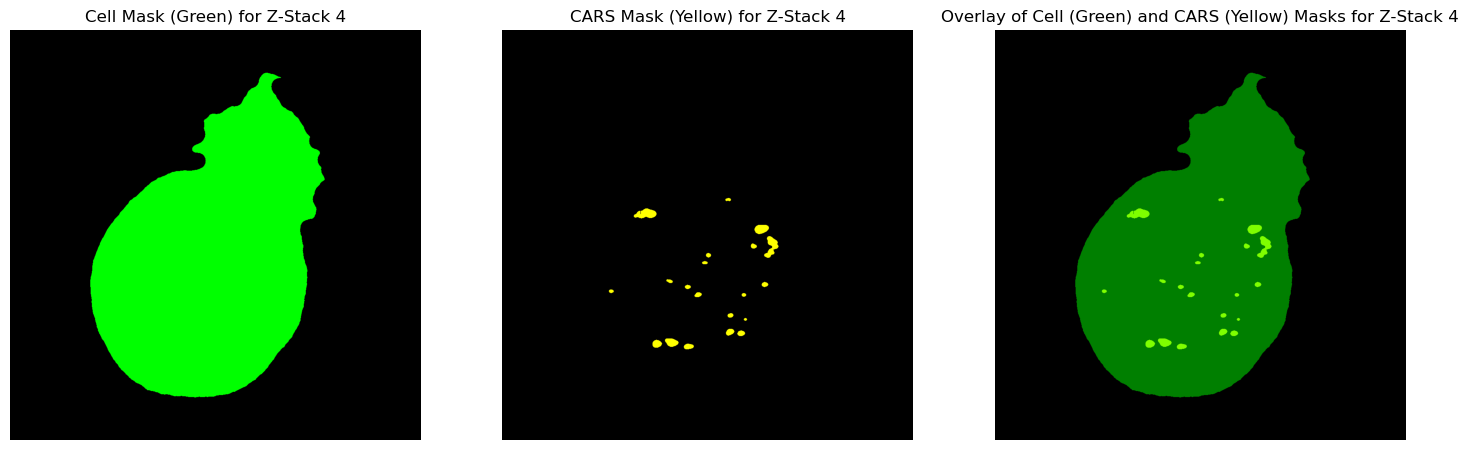


Processing Z-Stack 5


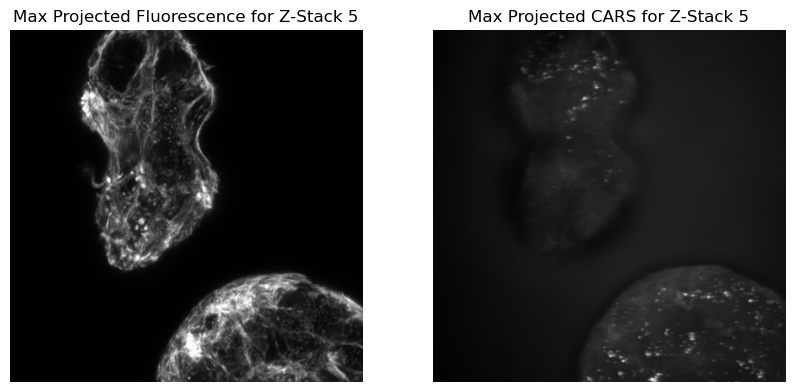

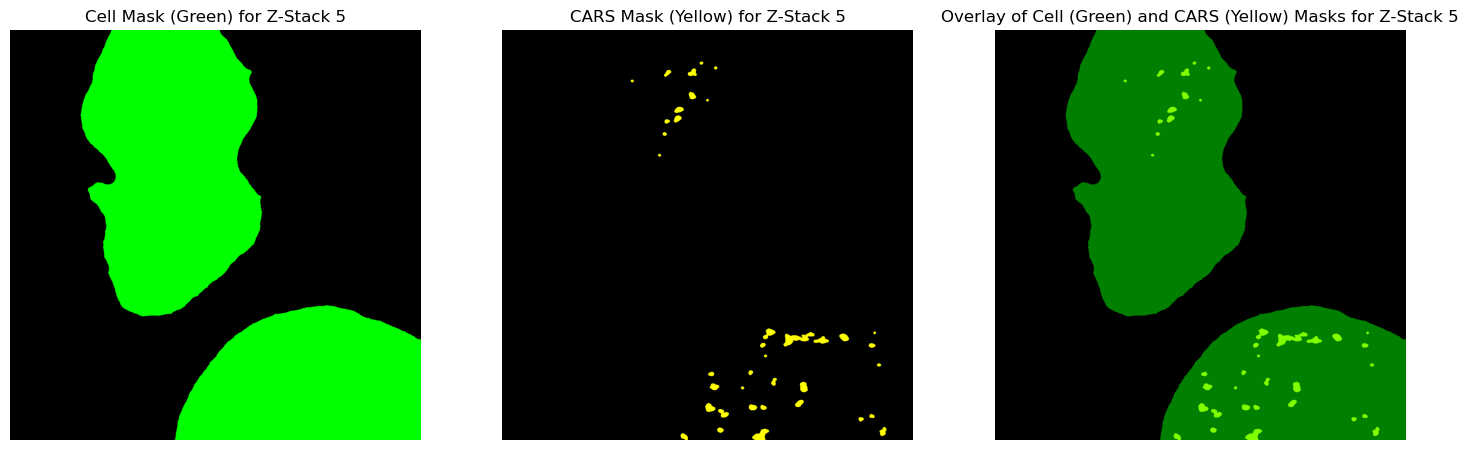

Results saved to analysis_results.xlsx


In [1]:
import os
import pandas as pd
from nd2reader import ND2Reader
import numpy as np
from skimage import filters, measure, morphology, feature, segmentation
from skimage.morphology import opening, closing, disk, remove_small_objects, binary_dilation
from skimage.segmentation import watershed
from skimage.filters import gaussian, threshold_otsu, threshold_triangle
from skimage.color import label2rgb
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

# Function to find and pair fluorescence and CARS .nd2 files in a directory
def find_nd2_files(directory):
    fluorescence_files = {}
    cars_files = {}
    for file in os.listdir(directory):
        # Only process .nd2 files with "100X" in the filename
        if file.endswith('.nd2') and '100X' in file:
            file_path = os.path.join(directory, file)
            # Separate CARS files from fluorescence files based on filename patterns
            if 'CARS' in file:
                key = get_file_key(file)
                cars_files[key] = file_path
            elif any(x in file for x in ['DAPI', 'Phalloidin']):
                key = get_file_key(file)
                fluorescence_files[key] = file_path
    # Pair fluorescence and CARS files based on matching keys
    paired_files = {key: {'fluorescence': fluorescence_files[key], 'CARS': cars_files[key]} 
                    for key in fluorescence_files if key in cars_files}
    return paired_files

# Function to extract a unique key for pairing based on filename structure
def get_file_key(filename):
    parts = filename.replace('.nd2', '').split('-')
    known_substrings = ['DAPI', 'Phalloidin', '100X']
    # Remove known substrings to isolate the unique identifier
    parts_filtered = [part for part in parts if part not in known_substrings and 'CARS' not in part]
    return '-'.join(parts_filtered)

# Function to process a single fluorescence image slice and create a binary mask
def process_fluorescence_channel(image_slice, min_size, closing_radius, gaussian_sigma, fill_holes):
    # Ensure input is a 2D image
    if image_slice.ndim != 2:
        raise ValueError(f"Expected a 2D array, but got shape {image_slice.shape}")
    
    # Replace NaNs with zeros
    image_slice = np.nan_to_num(image_slice)
    # Apply Gaussian smoothing
    smoothed_image = gaussian(image_slice, sigma=gaussian_sigma)
    # Apply Otsu's threshold to generate binary mask
    threshold_value = threshold_triangle(smoothed_image)
    binary_mask = smoothed_image > threshold_value
    
    # Perform morphological closing to connect structures
    binary_closed = closing(binary_mask, disk(closing_radius))
    # Optionally fill holes within the mask
    if fill_holes:
        binary_closed = ndi.binary_fill_holes(binary_closed)

    binary_mask = binary_dilation(binary_mask, disk(3))
    
    # Remove small objects to reduce background noise
    cleaned_mask = remove_small_objects(binary_closed, min_size=min_size)
    return cleaned_mask

# Function to identify foci within a CARS image slice using local maxima
def find_foci(image_slice, sigma, min_distance, min_size, std_dev_multiplier):
    image_slice = np.nan_to_num(image_slice)
    # Smooth the image
    smoothed_image = gaussian(image_slice, sigma=sigma)
    # Threshold using mean and standard deviation
    mean_value = np.mean(smoothed_image)
    std_dev = np.std(smoothed_image)
    threshold_value = mean_value + (std_dev_multiplier * std_dev)
    binary_std_dev_threshold = smoothed_image > threshold_value
    # Apply global Otsu threshold
    global_thresh = threshold_otsu(smoothed_image)
    binary_global = smoothed_image > global_thresh
    # Combine the two masks
    combined_mask = binary_global & binary_std_dev_threshold
    # Morphologically open to clean up small noise
    binary_opened = opening(combined_mask, disk(3))
    
    # Find local maxima
    distance = ndi.distance_transform_edt(binary_opened)
    local_maxi_coords = feature.peak_local_max(smoothed_image, min_distance=min_distance, labels=binary_opened)
    local_maxi = np.zeros_like(binary_opened, dtype=bool)
    local_maxi[tuple(local_maxi_coords.T)] = True
    
    # Perform watershed segmentation
    markers = ndi.label(local_maxi)[0]
    labels = segmentation.watershed(-distance, markers, mask=binary_opened)
    
    # Filter by area to create the final mask
    final_mask = np.zeros_like(labels, dtype=bool)
    for region in measure.regionprops(labels):
        if region.area >= min_size:
            final_mask[tuple(region.coords.T)] = True
    
    return final_mask

# Function to analyze lipid inclusions within each cell in the image
def analyze_intracellular_objects(cars_mask, cell_mask, cars_image, file_name, z_stack, pixel_size_microns):
    """
    Analyzes lipid inclusions within each cell in the image.

    Parameters:
        cars_mask (ndarray): Mask for CARS lipid droplets.
        cell_mask (ndarray): Mask for cells.
        cars_image (ndarray): Original CARS image.
        file_name (str): Name of the .nd2 file being processed.
        z_stack (int): Current z-stack being analyzed.

    Returns:
        results (list of dict): List of dictionaries containing lipid properties with file and z-stack context.
    """
    # Label connected regions in the cell and lipid masks
    labeled_cells = measure.label(cell_mask)
    labeled_lipids = measure.label(cars_mask)
    results = []

    # Iterate over each cell region
    for cell in measure.regionprops(labeled_cells):
        cell_id = cell.label
        cell_area = cell.area
        cell_mask_region = labeled_cells == cell_id
        lipid_objects_in_cell = labeled_lipids * cell_mask_region

        # Calculate properties of each lipid object within the cell
        for lipid in measure.regionprops(lipid_objects_in_cell, intensity_image=cars_image):
            lipid_size_pixels = lipid.area
            lipid_size_um2 = lipid_size_pixels * (pixel_size_microns ** 2)  # Convert lipid area to square micrometers
            lipid_intensity = lipid.mean_intensity
            results.append({
                'file_name': file_name,            # Add file name context
                'z_stack': z_stack,                # Add z-stack context
                'cell_id': cell_id,                # Cell ID within the mask
                'cell_area': cell_area,            # Area of the cell in pixels
                'lipid_size_pixels': lipid_size_pixels,          # Area of the lipid droplet in pixels
                'lipid_size_um2': lipid_size_um2,
                'lipid_intensity': lipid_intensity # Mean intensity of the lipid droplet
            })

    return results

# Function to process paired fluorescence and CARS .nd2 files
def process_nd2_pair(fluorescence_path, cars_path):
    # Set parameters for image processing
    fluorescence_params = {'min_size': 500, 'closing_radius': 20, 'gaussian_sigma': 2.5, 'fill_holes': True}
    foci_params = {'sigma': 2, 'min_distance': 15, 'min_size': 35, 'std_dev_multiplier': 3}
    results = []

    # Determine which fluorescence channel to process based on filename
    target_channel_index = 1;

    with ND2Reader(fluorescence_path) as fluoro_nd2, ND2Reader(cars_path) as cars_nd2:
        print(f"File: {fluorescence_path}")
        print(f"Number of channels: {fluoro_nd2.sizes.get('c', 'N/A')}")
        print(f"Total number of z-stacks: {fluoro_nd2.sizes.get('v', 'N/A')}")
        print(f"Number of slices per z-stack: {fluoro_nd2.sizes.get('z', 'N/A')}")
    
        fluoro_nd2.iter_axes = 'v'
        cars_nd2.iter_axes = 'v'

        # Retrieve pixel size from metadata
        pixel_size_microns = fluoro_nd2.metadata['pixel_microns']
    
        # Limit the number of z-stacks for debugging purposes
        for pos in range(fluoro_nd2.sizes['v']):
            fluoro_nd2.default_coords['v'] = pos
            cars_nd2.default_coords['v'] = pos
    
            fluoro_mask_stack = []
            cars_foci_stack = []
    
            # Iterate through each z-stack
            print(f"\nProcessing Z-Stack {pos + 1}")

            # Retrieve the fluorescence and CARS channel slices for the current z-stack
            fluorescence_z_stack = [
                np.nan_to_num(fluoro_nd2.get_frame_2D(v=pos, c=target_channel_index, z=z_slice))
                for z_slice in range(fluoro_nd2.sizes['z'])
            ]
            cars_z_stack = [
                np.nan_to_num(cars_nd2.get_frame_2D(v=pos, c=2, z=z_slice))
                for z_slice in range(cars_nd2.sizes['z'])
            ]
    
            # Perform max projection across the 3 slices within each z-stack
            fluorescence_slice = np.max(np.array(fluorescence_z_stack), axis=0)
            cars_slice = np.max(np.array(cars_z_stack), axis=0)
    
            # Display max-projected slices to verify results visually
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(fluorescence_slice, cmap='gray')
            axs[0].set_title(f"Max Projected Fluorescence for Z-Stack {pos + 1}")
            axs[0].axis('off')
            axs[1].imshow(cars_slice, cmap='gray')
            axs[1].set_title(f"Max Projected CARS for Z-Stack {pos + 1}")
            axs[1].axis('off')
            plt.show()
    
            # Process each max-projected 2D slice
            fluorescence_mask = process_fluorescence_channel(fluorescence_slice, **fluorescence_params)
            cars_foci_mask = find_foci(cars_slice, **foci_params)
    
            fluoro_mask_stack.append(fluorescence_mask)
            cars_foci_stack.append(cars_foci_mask)
        
            # Combine results for the z-stack at the current position (pos)
            fluorescence_stack = np.max(fluoro_mask_stack, axis=0)
            cars_stack = np.max(cars_foci_stack, axis=0)
        
            # Analyze intracellular objects based on the combined masks
            pos_results = analyze_intracellular_objects(cars_stack, fluorescence_stack, cars_stack, 
                                            file_name=os.path.basename(fluorescence_path), 
                                            z_stack=pos + 1,
                                            pixel_size_microns=pixel_size_microns)
            results.extend(pos_results)

            # Visualization of individual masks and overlay with custom RGB colors and 50% opacity
            def create_rgb_mask(mask, color):
                rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)  # Start with a black background
                for i in range(3):  # Apply the color to each channel
                    rgb_mask[:, :, i] = mask * color[i]
                return rgb_mask

            # Define colors
            green = [0, 255, 0]  # RGB green for the cell mask
            yellow = [255, 255, 0]  # RGB yellow for the CARS mask

            # Create RGB masks
            cell_rgb_mask = create_rgb_mask(fluorescence_stack, green)
            cars_rgb_mask = create_rgb_mask(cars_stack, yellow)

            # Blend the two masks with 50% opacity
            overlay_rgb_mask = np.clip(0.5 * cell_rgb_mask + 0.5 * cars_rgb_mask, 0, 255).astype(np.uint8)

            # Display the masks
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))

            # Cell mask in pure green
            axs[0].imshow(cell_rgb_mask)
            axs[0].set_title(f"Cell Mask (Green) for Z-Stack {pos + 1}")
            axs[0].axis('off')

            # CARS mask in pure yellow
            axs[1].imshow(cars_rgb_mask)
            axs[1].set_title(f"CARS Mask (Yellow) for Z-Stack {pos + 1}")
            axs[1].axis('off')

            # Overlay of Cell and CARS masks with 50% opacity
            axs[2].imshow(overlay_rgb_mask)
            axs[2].set_title(f"Overlay of Cell (Green) and CARS (Yellow) Masks for Z-Stack {pos + 1}")
            axs[2].axis('off')

            plt.show()

    return results

# Function to save analysis results to an Excel file
def save_results_to_excel(results, output_file):
    df = pd.DataFrame(results)
    df.to_excel(output_file, index=False)

# Directory and output setup
directory = r'C:\Users\clchr\Downloads\Round 2'
output_file = 'analysis_results.xlsx'
paired_files = find_nd2_files(directory)

# Process each pair and save results
all_results = []
for key, files in paired_files.items():
    print(f"Processing pair: {key}")
    pair_results = process_nd2_pair(files['fluorescence'], files['CARS'])
    all_results.extend(pair_results)

# Save results to Excel
save_results_to_excel(all_results, output_file)
print(f"Results saved to {output_file}")
